# 1. Imports

In [1]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt1
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pylab as plt2
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans
import math, pickle, os
import xgboost
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo
import numpy as np
# grid search holt winter's exponential smoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 2. Loading the dataset

## 2.1 Jan-2016 Data

In [2]:
jan_data = dd.read_csv('yellow_tripdata_2016-01.csv')

In [3]:
print(jan_data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
jan_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-01-01 00:00:00   2016-01-01 00:00:00                2   
1         2  2016-01-01 00:00:00   2016-01-01 00:00:00                5   
2         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
3         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
4         2  2016-01-01 00:00:00   2016-01-01 00:00:00                3   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.10        -73.990372        40.734695           1   
1           4.90        -73.980782        40.729912           1   
2          10.54        -73.984550        40.679565           1   
3           4.75        -73.993469        40.718990           1   
4           1.76        -73.960625        40.781330           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.981842         40.732407             2   
1                  N         -73.944473         40.716679             1   
2                  N         -73.950272         40.788925             1   
3                  N         -73.962242         40.657333             2   
4                  N         -73.977264         40.758514             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          7.5    0.5      0.5         0.0           0.0   
1         18.0    0.5      0.5         0.0           0.0   
2         33.0    0.5      0.5         0.0           0.0   
3         16.5    0.0      0.5         0.0           0.0   
4          8.0    0.0      0.5         0.0           0.0   

   improvement_surcharge  total_amount  
0                    0.3           8.8  
1                    0.3          19.3  
2                    0.3          34.3  
3                    0.3          17.3  
4                    0.3           8.8

In [5]:
# query: check number of rows in dask dataframe; 
# source: https://stackoverflow.com/a/58624383/10974488

print(len(jan_data.index))

10906858


## 2.2 Feb-2016 Data

In [3]:
feb_data = dd.read_csv('yellow_tripdata_2016-02.csv')

In [7]:
print(feb_data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [8]:
feb_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-02-25 17:24:20   2016-02-25 17:27:20                2   
1         2  2016-02-25 23:10:50   2016-02-25 23:31:50                2   
2         2  2016-02-01 00:00:01   2016-02-01 00:10:52                6   
3         1  2016-02-01 00:00:04   2016-02-01 00:05:16                1   
4         2  2016-02-01 00:00:05   2016-02-01 00:20:59                1   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           0.70        -73.947250        40.763771           1   
1           5.52        -73.983017        40.750992           1   
2           1.99        -73.992340        40.758202           1   
3           1.50        -73.981453        40.749722           1   
4           5.60        -74.000603        40.729755           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.992012         40.735390             2   
1                  N         -73.988586         40.758839             2   
2                  N         -73.964355         40.757977             1   
3                  N         -73.982323         40.763985             2   
4                  N         -73.951324         40.669834             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          5.0    0.0      0.5         0.0           0.0   
1         20.0    0.5      0.5         0.0           0.0   
2          9.5    0.5      0.5         0.7           0.0   
3          6.5    0.5      0.5         0.0           0.0   
4         20.0    0.5      0.5         4.0           0.0   

   improvement_surcharge  total_amount  
0                    0.3           5.8  
1                    0.3          21.3  
2                    0.3          11.5  
3                    0.3           7.8  
4                    0.3          25.3

In [9]:
# query: check number of rows in dask dataframe; 
# source: https://stackoverflow.com/a/58624383/10974488

print(len(feb_data.index))

11382049


## 2.3 Mar-2016 Data

In [4]:
mar_data = dd.read_csv('yellow_tripdata_2016-03.csv')

In [11]:
print(mar_data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [12]:
mar_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2016-03-01 00:00:00   2016-03-01 00:07:55                1   
1         1  2016-03-01 00:00:00   2016-03-01 00:11:06                1   
2         2  2016-03-01 00:00:00   2016-03-01 00:31:06                2   
3         2  2016-03-01 00:00:00   2016-03-01 00:00:00                3   
4         2  2016-03-01 00:00:00   2016-03-01 00:00:00                5   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           2.50        -73.976746        40.765152           1   
1           2.90        -73.983482        40.767925           1   
2          19.98        -73.782021        40.644810           1   
3          10.78        -73.863419        40.769814           1   
4          30.43        -73.971741        40.792183           3   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -74.004265         40.746128             1   
1                  N         -74.005943         40.733166             1   
2                  N         -73.974541         40.675770             1   
3                  N         -73.969650         40.757767             1   
4                  N         -74.177170         40.695053             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          9.0    0.5      0.5        2.05          0.00   
1         11.0    0.5      0.5        3.05          0.00   
2         54.5    0.5      0.5        8.00          0.00   
3         31.5    0.0      0.5        3.78          5.54   
4         98.0    0.0      0.0        0.00         15.50   

   improvement_surcharge  total_amount  
0                    0.3         12.35  
1                    0.3         15.35  
2                    0.3         63.80  
3                    0.3         41.62  
4                    0.3        113.80

In [13]:
# query: check number of rows in dask dataframe; 
# source: https://stackoverflow.com/a/58624383/10974488

print(len(mar_data.index))

12210952


# 3. Visualizing the Data (Only Jan - 2016)

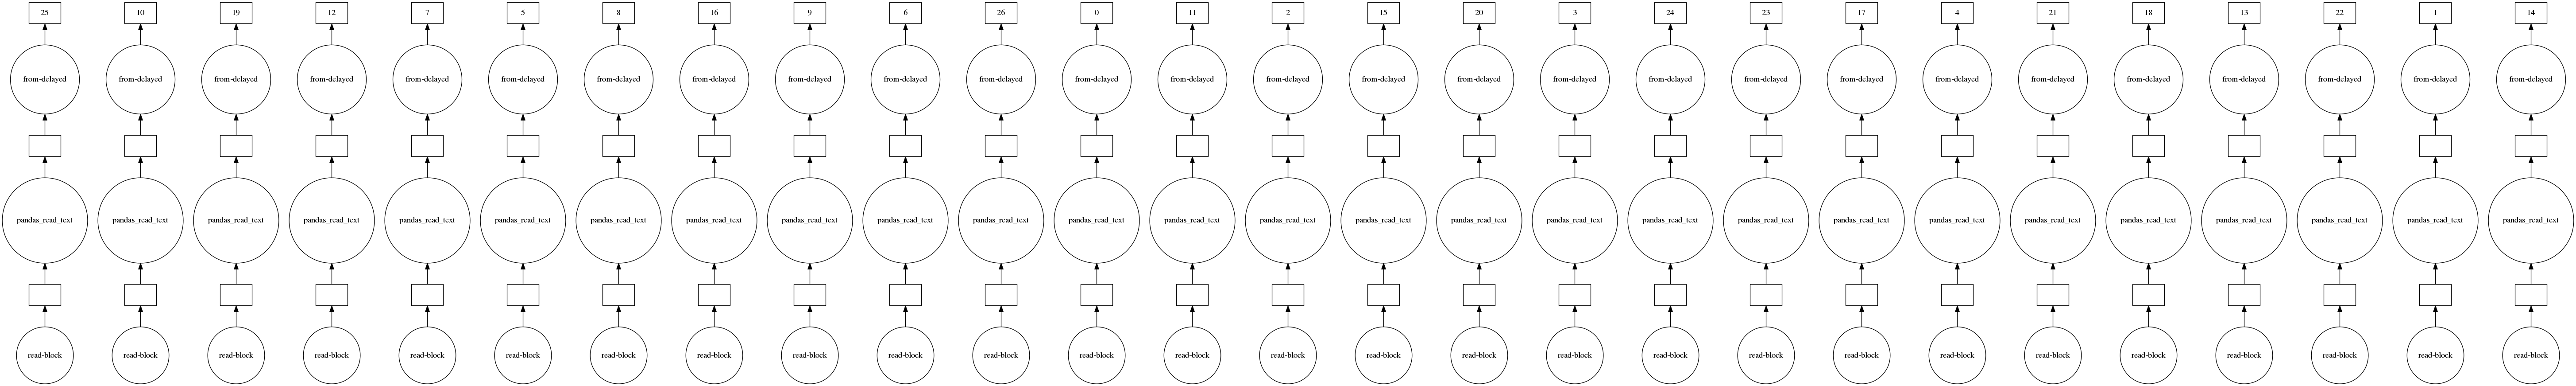

In [14]:
jan_data.visualize()

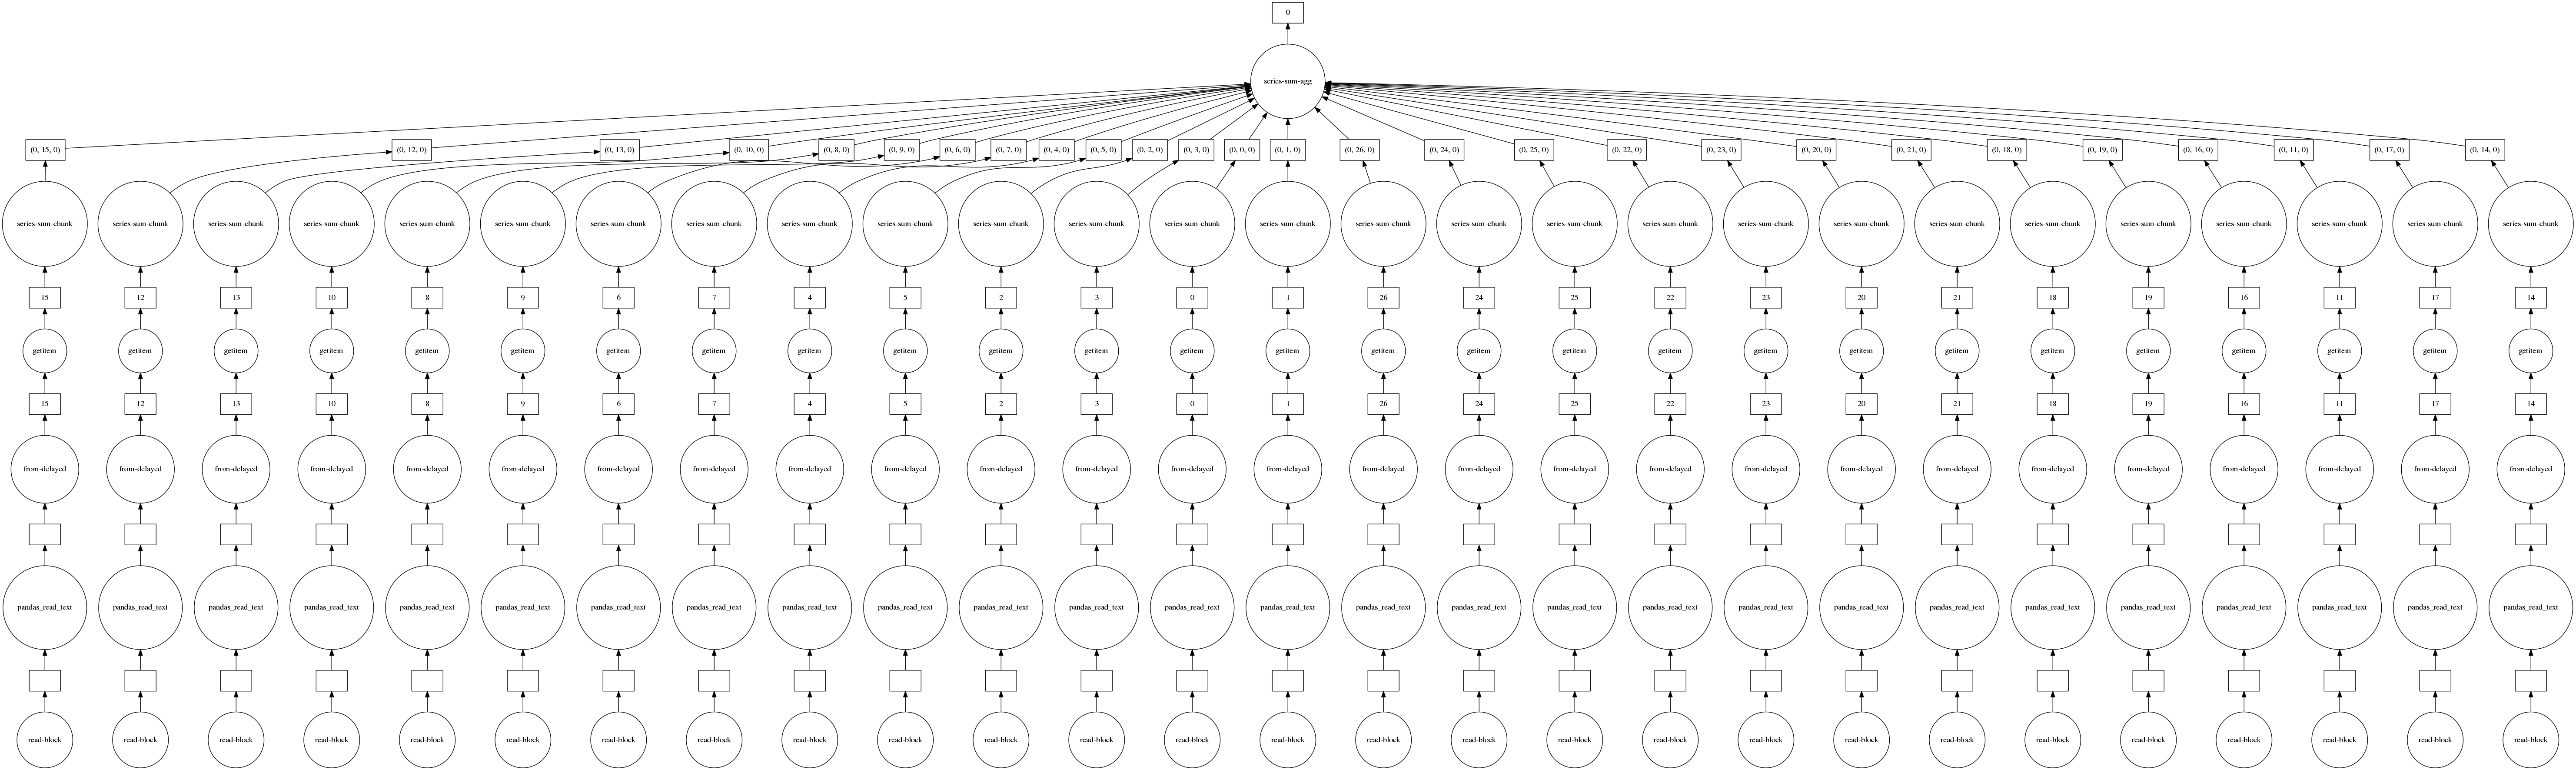

In [15]:
jan_data.fare_amount.sum().visualize()

# ML Problem Formulation

1. We need to find the number of pickups, given the location coordinates(lattitude and longitude) and time, in the query region and surrounding regions.
2. To solve the above we would be using data collected in Jan, Feb 2016 to predict the pickups in Mar-2016.

# Performance Metrics

1. Mean Absolute Percentage Error(MAPE)
2. Mean Squared Error(MSE)

# 4. Data Cleaning

## 4.1 Outlier points based on Pickup Latitude and Longitude:

### New York bounding box:

1. min_lat = 40.5774
2. max_lat = 40.9176
3. min_long = -74.15
4. max_long = -73.7004   

#### 4.1.1 Jan-2016

In [16]:
min_lat = 40.5774
max_lat = 40.9176
min_long = -74.15
max_long = -73.7004

# The or and and python statements require truth-values. 
# For pandas these are considered ambiguous so you should use "bitwise" | (or) or & (and) operations.

jan_data_outlier_locations1 = jan_data[((jan_data.pickup_longitude != 0) & \
                               (jan_data.pickup_latitude != 0)) & \
                               ((jan_data.pickup_longitude <= min_long) | \
                                (jan_data.pickup_latitude <= min_lat) | \
                                (jan_data.pickup_longitude >= max_long) | \
                                (jan_data.pickup_latitude >= max_lat))]

In [17]:
jan_map_osm1 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')
jan_sample_locations1 = jan_data_outlier_locations1.head(10000)

for i, j in jan_sample_locations1.iterrows():
    folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(jan_map_osm1)

jan_map_osm1

#### 4.1.2 Feb-2016

In [18]:
min_lat = 40.5774
max_lat = 40.9176
min_long = -74.15
max_long = -73.7004

# The or and and python statements require truth-values. 
# For pandas these are considered ambiguous so you should use "bitwise" | (or) or & (and) operations.

feb_data_outlier_locations1 = feb_data[((feb_data.pickup_longitude != 0) & \
                               (feb_data.pickup_latitude != 0)) & \
                               ((feb_data.pickup_longitude <= min_long) | \
                                (feb_data.pickup_latitude <= min_lat) | \
                                (feb_data.pickup_longitude >= max_long) | \
                                (feb_data.pickup_latitude >= max_lat))]

In [19]:
feb_map_osm1 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')
feb_sample_locations1 = feb_data_outlier_locations1.head(10000)

for i, j in feb_sample_locations1.iterrows():
    folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(feb_map_osm1)

feb_map_osm1

As there are some points just outside the boundary but there are a few that are either in Canada, Europe or in the Atlantic Ocean, we need to discard those outliers.

## 4.2 Outlier points based on Dropoff Latitude and Longitude

### New York bounding box:

1. min_lat = 40.5774
2. max_lat = 40.9176
3. min_long = -74.15
4. max_long = -73.7004 

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [20]:
min_lat = 40.5774
max_lat = 40.9176
min_long = -74.15
max_long = -73.7004

#### 4.2.1 Jan - 2016

In [21]:
jan_outlier_locations2 = jan_data[((jan_data.dropoff_longitude <= min_long) | \
                                (jan_data.dropoff_latitude <= min_lat) | \
                                (jan_data.dropoff_longitude >= max_long) | \
                                (jan_data.dropoff_latitude >= max_lat))]

In [22]:
jan_map_osm2 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')

jan_sample_locations2 = jan_outlier_locations2.head(10000)

for i, j in jan_sample_locations2.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(jan_map_osm2)

jan_map_osm2

#### 4.2.2 Feb - 2016

In [23]:
feb_outlier_locations2 = feb_data[((feb_data.dropoff_longitude <= min_long) | \
                                (feb_data.dropoff_latitude <= min_lat) | \
                                (feb_data.dropoff_longitude >= max_long) | \
                                (feb_data.dropoff_latitude >= max_lat))]

In [24]:
feb_map_osm2 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')

feb_sample_locations2 = feb_outlier_locations2.head(10000)

for i, j in jan_sample_locations2.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(feb_map_osm2)

feb_map_osm2

As we can see, there are so many dropoff points which lie in New Jersey, Philadelphia. Not even that, they also lie in South America and in Atlantic Ocean near African continent.

## Data Cleaning of Pickup and Dropoff Latitude & Longitude. Calculating Trip Durations

In [25]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405

def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

#### For Jan-2016

##### Returning Trip Times

In [26]:
jan_data_with_durations = return_with_trip_times(jan_data)

##### Visualization after returning trip times

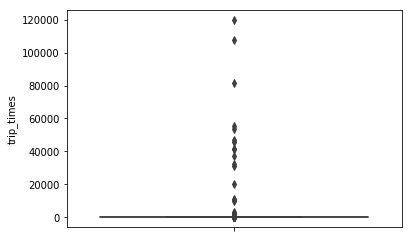

In [27]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =jan_data_with_durations)
plt1.show()

In [28]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =jan_data_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -43.95
10 percentile value is 3.933333333333333
20 percentile value is 5.566666666666666
30 percentile value is 7.1
40 percentile value is 8.683333333333334
50 percentile value is 10.466666666666667
60 percentile value is 12.55
70 percentile value is 15.2
80 percentile value is 18.933333333333334
90 percentile value is 25.516666666666666
100 percentile value is  119912.7


In [29]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =jan_data_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.516666666666666
91 percentile value is 26.55
92 percentile value is 27.733333333333334
93 percentile value is 29.116666666666667
94 percentile value is 30.733333333333334
95 percentile value is 32.7
96 percentile value is 35.233333333333334
97 percentile value is 38.666666666666664
98 percentile value is 43.916666666666664
99 percentile value is 53.9
100 percentile value is  119912.7


##### Durations modified

In [30]:
#removing data based on our analysis and TLC regulations
jan_data_with_durations_modified=jan_data_with_durations[(jan_data_with_durations.trip_times>1) & (jan_data_with_durations.trip_times<720)]

##### Visualization after modification

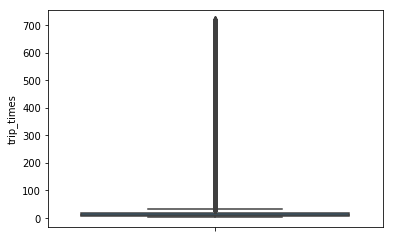

In [31]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =jan_data_with_durations_modified)
plt1.show()

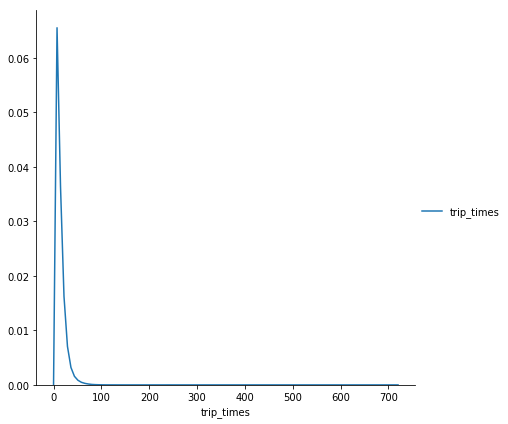

In [32]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(jan_data_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt1.show();

##### Converting to log-normal

In [33]:
#converting the values to log-values to check for log-normal
import math
jan_data_with_durations_modified['log_times']=[math.log(i) for i in jan_data_with_durations_modified['trip_times'].values]

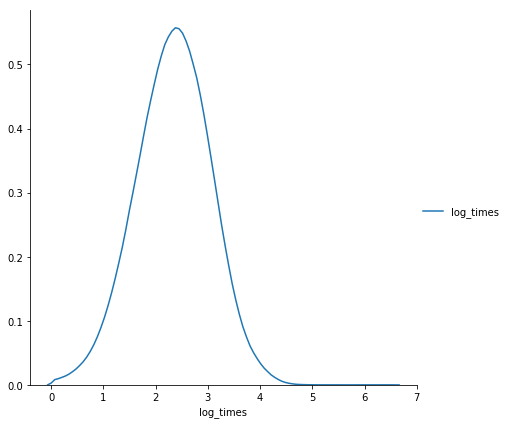

In [34]:
#pdf of log-values
sns.FacetGrid(jan_data_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt1.show();

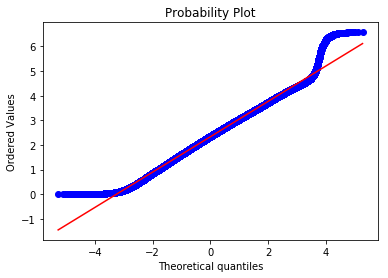

In [35]:
#Q-Q plot for checking if trip-times is log-normal
import scipy

scipy.stats.probplot(jan_data_with_durations_modified['log_times'].values, plot=plt1)
plt1.show()

#### For Feb-2016

##### Returning Trip Times

In [36]:
feb_data_with_durations = return_with_trip_times(feb_data)

##### Visualization after returning trip times

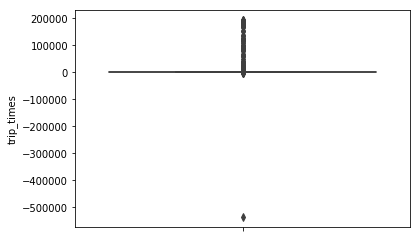

In [37]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =feb_data_with_durations)
plt1.show()

In [38]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =feb_data_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -537100.0666666667
10 percentile value is 3.933333333333333
20 percentile value is 5.583333333333333
30 percentile value is 7.15
40 percentile value is 8.766666666666667
50 percentile value is 10.55
60 percentile value is 12.666666666666666
70 percentile value is 15.333333333333334
80 percentile value is 19.05
90 percentile value is 25.483333333333334
100 percentile value is  192313.38333333333


In [39]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =feb_data_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.483333333333334
91 percentile value is 26.483333333333334
92 percentile value is 27.616666666666667
93 percentile value is 28.916666666666668
94 percentile value is 30.45
95 percentile value is 32.3
96 percentile value is 34.666666666666664
97 percentile value is 37.81666666666667
98 percentile value is 42.53333333333333
99 percentile value is 51.18333333333333
100 percentile value is  192313.38333333333


##### Durations modified

In [40]:
#removing data based on our analysis and TLC regulations
feb_data_with_durations_modified=feb_data_with_durations[(feb_data_with_durations.trip_times>1) & (feb_data_with_durations.trip_times<720)]

##### Visualization after modification

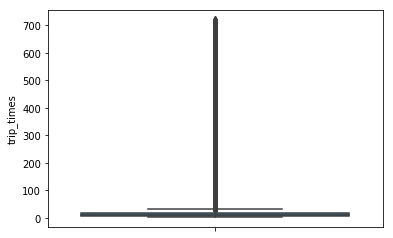

In [41]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =feb_data_with_durations_modified)
plt1.show()

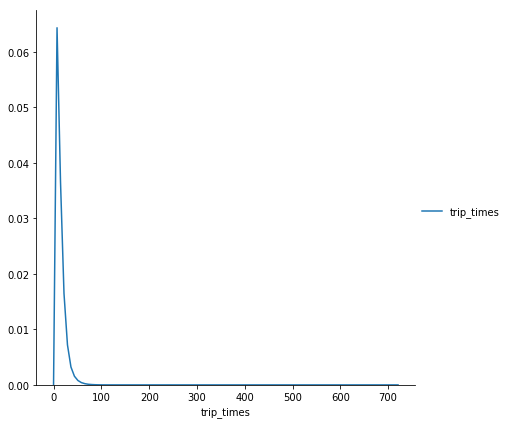

In [42]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(feb_data_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt1.show();

##### Converting to log-normal

In [43]:
#converting the values to log-values to check for log-normal
import math
feb_data_with_durations_modified['log_times']=[math.log(i) for i in feb_data_with_durations_modified['trip_times'].values]

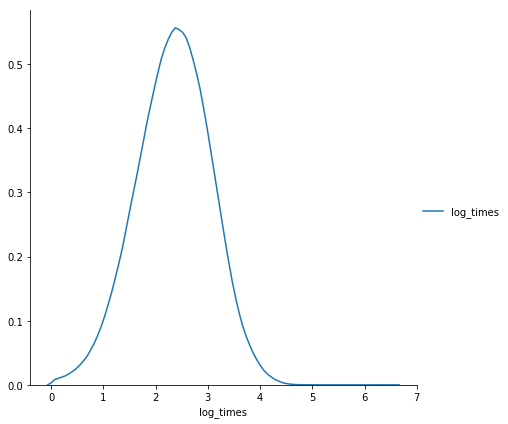

In [44]:
#pdf of log-values
sns.FacetGrid(feb_data_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt1.show();

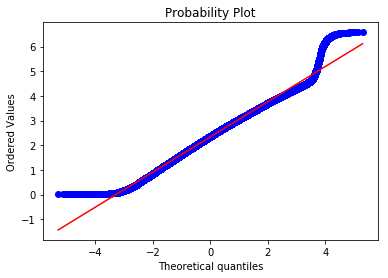

In [45]:
#Q-Q plot for checking if trip-times is log-normal
import scipy

scipy.stats.probplot(feb_data_with_durations_modified['log_times'].values, plot=plt1)
plt1.show()

#### For March-2016

##### Returning Trip Times

In [46]:
mar_data_with_durations = return_with_trip_times(mar_data)

##### Durations modified

In [50]:
#removing data based on our analysis and TLC regulations

# query: 'ValueError: math domain error'
# source: https://stackoverflow.com/a/15890593
mar_data_with_durations_modified=mar_data_with_durations[(mar_data_with_durations.trip_times>0)]

##### Converting to log-normal

In [51]:
#converting the values to log-values to check for log-normal
import math
mar_data_with_durations_modified['log_times']=[math.log(i) for i in mar_data_with_durations_modified['trip_times'].values]

## 4.3 Outlier points based on Speed

#### Jan-2016

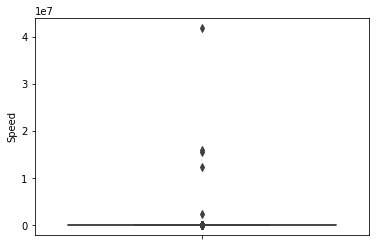

In [52]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
jan_data_with_durations_modified['Speed'] = 60*(jan_data_with_durations_modified['trip_distance']/jan_data_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =jan_data_with_durations_modified)
plt1.show()

In [53]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =jan_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.011787819253438
20 percentile value is 7.390029325513196
30 percentile value is 8.49689440993789
40 percentile value is 9.545454545454543
50 percentile value is 10.638522427440636
60 percentile value is 11.87948350071736
70 percentile value is 13.432835820895523
80 percentile value is 15.6734693877551
90 percentile value is 20.035906642728904
100 percentile value is  41917233.8028169


In [54]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =jan_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.035906642728904
91 percentile value is 20.77922077922078
92 percentile value is 21.62544169611307
93 percentile value is 22.594142259414227
94 percentile value is 23.720930232558143
95 percentile value is 25.043478260869566
96 percentile value is 26.641366223908914
97 percentile value is 28.652097902097903
98 percentile value is 31.304347826086957
99 percentile value is 35.33428165007113
100 percentile value is  41917233.8028169


In [55]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =jan_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.33428165007113
99.1 percentile value is 35.89123867069487
99.2 percentile value is 36.49769585253456
99.3 percentile value is 37.17507418397626
99.4 percentile value is 37.91878172588833
99.5 percentile value is 38.762376237623755
99.6 percentile value is 39.768642447418735
99.7 percentile value is 41.019230769230774
99.8 percentile value is 42.63212435233161
99.9 percentile value is 45.163636363636364
100 percentile value is  41917233.8028169


In [56]:
#removing further outliers based on the 99.9th percentile value
jan_data_with_durations_modified=jan_data_with_durations[(jan_data_with_durations.Speed>0) & (jan_data_with_durations.Speed<45.16)]

In [57]:
#avg.speed of cabs in New-York
sum(jan_data_with_durations_modified["Speed"]) / float(len(jan_data_with_durations_modified["Speed"]))

12.07741116786621

The avg speed in Newyork speed is 12.07miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.

#### Feb-2016

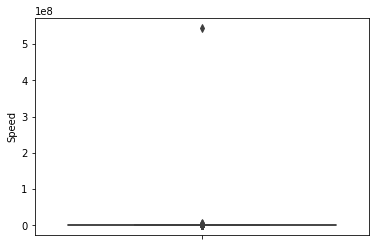

In [58]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
feb_data_with_durations_modified['Speed'] = 60*(feb_data_with_durations_modified['trip_distance']/feb_data_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =feb_data_with_durations_modified)
plt1.show()

In [59]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =feb_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.96319018404908
20 percentile value is 7.297297297297297
30 percentile value is 8.379310344827587
40 percentile value is 9.409090909090908
50 percentile value is 10.482100238663485
60 percentile value is 11.698870765370138
70 percentile value is 13.222222222222221
80 percentile value is 15.418705035971222
90 percentile value is 19.66284558327714
100 percentile value is  545074330.9090909


In [60]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =feb_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.66284558327714
91 percentile value is 20.377358490566035
92 percentile value is 21.19370591427021
93 percentile value is 22.145772594752184
94 percentile value is 23.23584
95 percentile value is 24.529058116232466
96 percentile value is 26.08695652173913
97 percentile value is 28.061946902654867
98 percentile value is 30.752688172043015
99 percentile value is 34.96209289909237
100 percentile value is  545074330.9090909


In [61]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =feb_data_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 34.96209289909237
99.1 percentile value is 35.54716981132076
99.2 percentile value is 36.181512605042016
99.3 percentile value is 36.88609044075558
99.4 percentile value is 37.66153846153847
99.5 percentile value is 38.53372434017595
99.6 percentile value is 39.56896551724138
99.7 percentile value is 40.80604534005038
99.8 percentile value is 42.401372212692976
99.9 percentile value is 44.86730268863833
100 percentile value is  545074330.9090909


In [62]:
#removing further outliers based on the 99.9th percentile value
feb_data_with_durations_modified=feb_data_with_durations[(feb_data_with_durations.Speed>0) & (feb_data_with_durations.Speed<44.86)]

In [63]:
#avg.speed of cabs in New-York
sum(feb_data_with_durations_modified["Speed"]) / float(len(feb_data_with_durations_modified["Speed"]))

11.898234830711848

The avg speed in Newyork speed is 11.89miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.

#### March-2016

In [64]:
mar_data_with_durations_modified['Speed'] = 60*(mar_data_with_durations_modified['trip_distance']/mar_data_with_durations_modified['trip_times'])

In [65]:
#removing further outliers based on the 99.9th percentile value
mar_data_with_durations_modified=mar_data_with_durations

In [67]:
#with open('cleaning_till_speed.pickle', 'wb') as f:
 #   pickle.dump([jan_data_with_durations_modified, feb_data_with_durations_modified, mar_data_with_durations_modified], f)

In [7]:
with open('cleaning_till_speed.pickle', 'rb') as f:
    jan_data_with_durations_modified, feb_data_with_durations_modified, mar_data_with_durations_modified = pickle.load(f)

## 4.4 Outlier points based on Trip Distance

#### Jan-2016

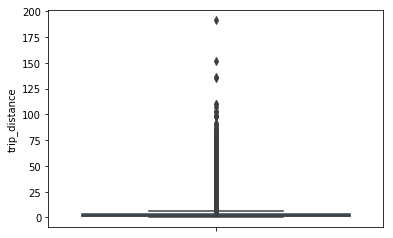

In [69]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =jan_data_with_durations_modified)
plt1.show()

In [70]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =jan_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.69
60 percentile value is 2.08
70 percentile value is 2.64
80 percentile value is 3.7
90 percentile value is 6.5
100 percentile value is  191.9


In [71]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =jan_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.5
91 percentile value is 7.1
92 percentile value is 7.88
93 percentile value is 8.7
94 percentile value is 9.48
95 percentile value is 10.3
96 percentile value is 11.4
97 percentile value is 13.5
98 percentile value is 16.97
99 percentile value is 18.59
100 percentile value is  191.9


In [72]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =jan_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.59
99.1 percentile value is 18.8
99.2 percentile value is 19.01
99.3 percentile value is 19.3
99.4 percentile value is 19.61
99.5 percentile value is 20.0
99.6 percentile value is 20.5
99.7 percentile value is 21.0
99.8 percentile value is 21.78
99.9 percentile value is 23.89
100 percentile value is  191.9


In [73]:
#removing further outliers based on the 99.9th percentile value
jan_data_with_durations_modified=jan_data_with_durations[(jan_data_with_durations.trip_distance>0) & (jan_data_with_durations.trip_distance<24)]

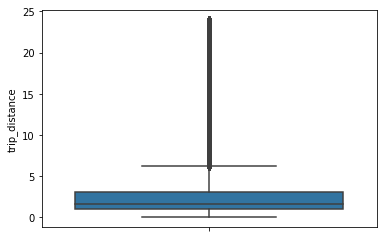

In [74]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = jan_data_with_durations_modified)
plt1.show()

#### Feb-2016

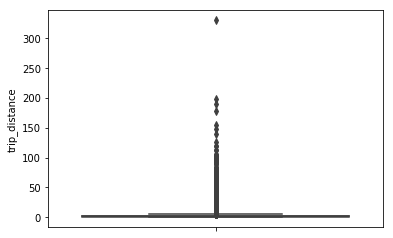

In [75]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =feb_data_with_durations_modified)
plt1.show()

In [76]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =feb_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.64
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.37
50 percentile value is 1.67
60 percentile value is 2.06
70 percentile value is 2.62
80 percentile value is 3.66
90 percentile value is 6.36
100 percentile value is  330.0


In [77]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =feb_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.36
91 percentile value is 6.9
92 percentile value is 7.63
93 percentile value is 8.47
94 percentile value is 9.22
95 percentile value is 10.06
96 percentile value is 11.05
97 percentile value is 12.74
98 percentile value is 16.51
99 percentile value is 18.35
100 percentile value is  330.0


In [78]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =feb_data_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.35
99.1 percentile value is 18.56
99.2 percentile value is 18.8
99.3 percentile value is 19.09
99.4 percentile value is 19.4
99.5 percentile value is 19.8
99.6 percentile value is 20.28
99.7 percentile value is 20.81
99.8 percentile value is 21.56
99.9 percentile value is 23.2
100 percentile value is  330.0


In [79]:
#removing further outliers based on the 99.9th percentile value
feb_data_with_durations_modified=feb_data_with_durations[(feb_data_with_durations.trip_distance>0) & (feb_data_with_durations.trip_distance<24)]

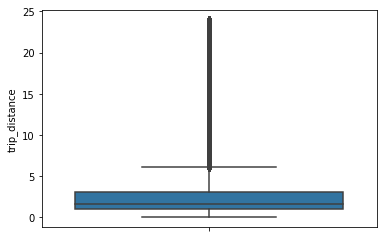

In [80]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = feb_data_with_durations_modified)
plt1.show()

#### March-2016

In [81]:
#removing further outliers based on the 99.9th percentile value
mar_data_with_durations_modified=mar_data_with_durations

In [82]:
#with open('cleaning_till_trip_distance.pickle', 'wb') as f:
 #   pickle.dump([jan_data_with_durations_modified, feb_data_with_durations_modified, mar_data_with_durations_modified], f)

In [83]:
with open('cleaning_till_trip_distance.pickle', 'rb') as f:
    jan_data_with_durations_modified, feb_data_with_durations_modified, mar_data_with_durations_modified = pickle.load(f)

## 4.5 Outlier points based on Total Fare

#### Jan-2016

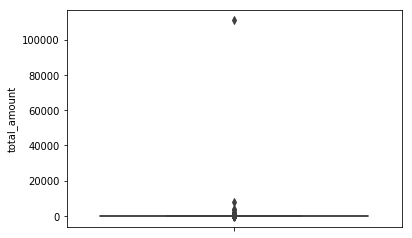

In [84]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =jan_data_with_durations_modified)
plt1.show()

In [85]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = jan_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -958.4
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.62
60 percentile value is 13.3
70 percentile value is 15.36
80 percentile value is 19.3
90 percentile value is 28.08
100 percentile value is  111271.65


In [86]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = jan_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 28.08
91 percentile value is 30.14
92 percentile value is 32.54
93 percentile value is 35.38
94 percentile value is 38.8
95 percentile value is 42.36
96 percentile value is 46.8
97 percentile value is 52.8
98 percentile value is 58.8
99 percentile value is 69.99
100 percentile value is  111271.65


In [87]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = jan_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 69.99
99.1 percentile value is 69.99
99.2 percentile value is 70.01
99.3 percentile value is 70.01
99.4 percentile value is 70.01
99.5 percentile value is 70.01
99.6 percentile value is 72.89
99.7 percentile value is 72.96
99.8 percentile value is 79.3
99.9 percentile value is 93.36
100 percentile value is  111271.65


As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

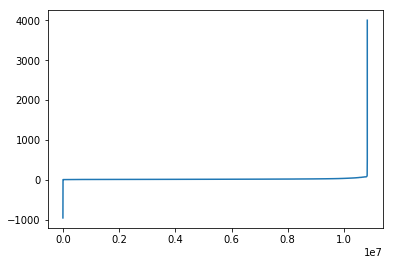

In [88]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt1.plot(var[:-2])
plt1.show()

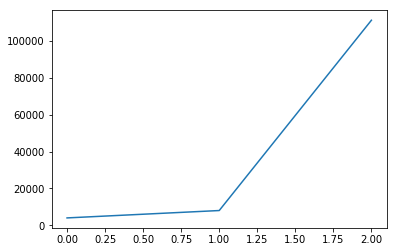

In [89]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt1.plot(var[-3:])
plt1.show()

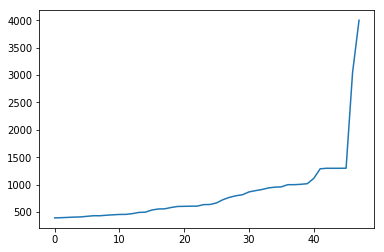

In [90]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt1.plot(var[-50:-2])
plt1.show()

#### Feb-2016

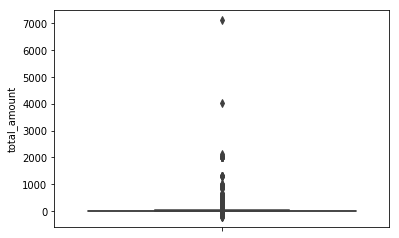

In [91]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =feb_data_with_durations_modified)
plt1.show()

In [92]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = feb_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -234.8
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.75
60 percentile value is 13.3
70 percentile value is 15.36
80 percentile value is 19.3
90 percentile value is 27.85
100 percentile value is  7122.16


In [93]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = feb_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.85
91 percentile value is 29.75
92 percentile value is 31.8
93 percentile value is 34.8
94 percentile value is 38.16
95 percentile value is 41.75
96 percentile value is 45.8
97 percentile value is 51.79
98 percentile value is 58.34
99 percentile value is 69.99
100 percentile value is  7122.16


In [94]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = feb_data_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 69.99
99.1 percentile value is 69.99
99.2 percentile value is 70.01
99.3 percentile value is 70.01
99.4 percentile value is 70.01
99.5 percentile value is 72.84
99.6 percentile value is 72.92
99.7 percentile value is 75.41
99.8 percentile value is 80.16
99.9 percentile value is 94.75
100 percentile value is  7122.16


As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

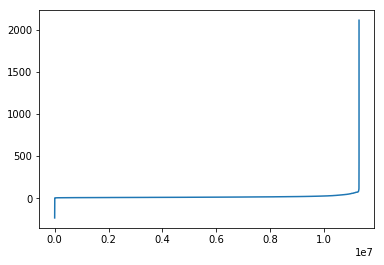

In [95]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt1.plot(var[:-2])
plt1.show()

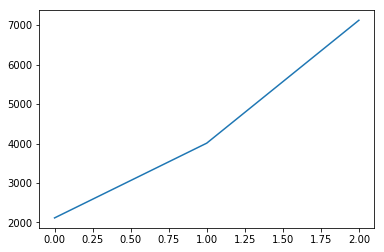

In [96]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt1.plot(var[-3:])
plt1.show()

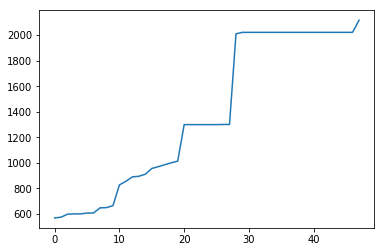

In [97]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt1.plot(var[-50:-2])
plt1.show()

## Removing all outliers and erronous points

In [98]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 24)]
    new_frame = new_frame[(new_frame.Speed < 44.00) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

#### Jan-2016

In [100]:
print ("Removing outliers in the month of Jan-2016")
print ("----")
jan_data_with_durations_outliers_removed = remove_outliers(jan_data_with_durations)
print("Fraction of data points that remain after removing outliers", float(len(jan_data_with_durations_outliers_removed))/len(jan_data_with_durations))

Removing outliers in the month of Jan-2016
----
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 299262
---
Fraction of data points that remain after removing outliers 0.9725620339056399


#### Feb-2016

In [101]:
print ("Removing outliers in the month of Feb-2016")
print ("----")
feb_data_with_durations_outliers_removed = remove_outliers(feb_data_with_durations)
print("Fraction of data points that remain after removing outliers", float(len(feb_data_with_durations_outliers_removed))/len(feb_data_with_durations))

Removing outliers in the month of Feb-2016
----
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 309954
---
Fraction of data points that remain after removing outliers 0.972768172057597


In [102]:
#with open('outliers_removed.pickle', 'wb') as f:
 #   pickle.dump([jan_data_with_durations_outliers_removed, feb_data_with_durations_outliers_removed, mar_data_with_durations_modified], f)

In [5]:
with open('outliers_removed.pickle', 'rb') as f:
    jan_data_with_durations_outliers_removed, feb_data_with_durations_outliers_removed, mar_data_with_durations_modified = pickle.load(f)
    

In [103]:
jan_data_with_durations_outliers_removed.shape

(10607596, 10)

In [106]:
jan_data_with_durations_outliers_removed.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
5                2           5.52        -73.980118        40.743050   
6                2           7.45        -73.994057        40.719990   
7                1           1.20        -73.979424        40.744614   
8                1           6.00        -73.947151        40.791046   
9                1           3.21        -73.998344        40.723896   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
5         -73.913490         40.763142          20.3       18.50   
6         -73.966362         40.789871          27.3       26.75   
7         -73.992035         40.753944          10.3       11.90   
8         -73.920769         40.865578          19.3       11.20   
9         -73.995850         40.688400          12.8       11.10   

   pickup_times      Speed  
5  1.451606e+09  17.902703  
6  1.451606e+09  16.710280  
7  1.451606e+09   6.050420  
8  1.451606e+09  32.142857  
9  1.451606e+09  17.351351

In [104]:
feb_data_with_durations_outliers_removed.shape

(11072095, 10)

In [107]:
feb_data_with_durations_outliers_removed.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                2           0.70        -73.947250        40.763771   
1                2           5.52        -73.983017        40.750992   
2                6           1.99        -73.992340        40.758202   
3                1           1.50        -73.981453        40.749722   
4                1           5.60        -74.000603        40.729755   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.992012         40.735390           5.8        3.00   
1         -73.988586         40.758839          21.3       21.00   
2         -73.964355         40.757977          11.5       10.85   
3         -73.982323         40.763985           7.8        5.20   
4         -73.951324         40.669834          25.3       20.90   

   pickup_times      Speed  
0  1.456421e+09  14.000000  
1  1.456442e+09  15.771429  
2  1.454285e+09  11.004608  
3  1.454285e+09  17.307692  
4  1.454285e+09  16.076555

In [105]:
mar_data_with_durations_modified.shape

(12210952, 10)

In [108]:
mar_data_with_durations_modified.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           2.50        -73.976746        40.765152   
1                1           2.90        -73.983482        40.767925   
2                2          19.98        -73.782021        40.644810   
3                3          10.78        -73.863419        40.769814   
4                5          30.43        -73.971741        40.792183   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -74.004265         40.746128         12.35    7.916667   
1         -74.005943         40.733166         15.35   11.100000   
2         -73.974541         40.675770         63.80   31.100000   
3         -73.969650         40.757767         41.62    0.000000   
4         -74.177170         40.695053        113.80    0.000000   

   pickup_times      Speed  
0  1.456790e+09  18.947368  
1  1.456790e+09  15.675676  
2  1.456790e+09  38.546624  
3  1.456790e+09        inf  
4  1.456790e+09        inf

# Data Preparation

## Clustering/Segmentation

#### Jan-2016

In [6]:
#trying different cluster sizes to choose the right K in K-means
coords = jan_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    jan_data_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(jan_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

           

In [12]:
# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len) 

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.8321714270306373 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.4954095349391212 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.45985476814093323 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance

##### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [7]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 30 clusters using the kmeans 
kmeans_jan = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
jan_data_with_durations_outliers_removed['pickup_cluster'] = kmeans_jan.predict(jan_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

#### Plotting the cluster centers

In [8]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans_jan.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### Plotting the Clusters

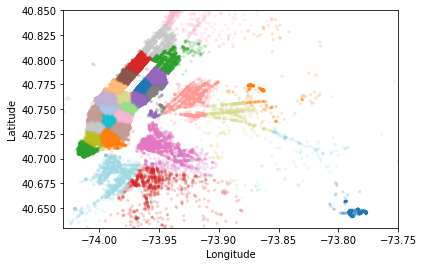

In [9]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt1.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt1.show()

plot_clusters(jan_data_with_durations_outliers_removed)

#### Feb-2016

In [10]:
#trying different cluster sizes to choose the right K in K-means
coords = feb_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    feb_data_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(feb_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

           

In [15]:
# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len) 

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 3.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 7.0 
Min inter-cluster distance =  1.0363663703515558 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6715128769650989 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.4978802780765134 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 30.0 
Min inter-cluster distance

##### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [11]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 30 clusters using the kmeans 
kmeans_feb = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
feb_data_with_durations_outliers_removed['pickup_cluster'] = kmeans_feb.predict(feb_data_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

#### Plotting the cluster centers

In [12]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans_feb.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### Plotting the Clusters

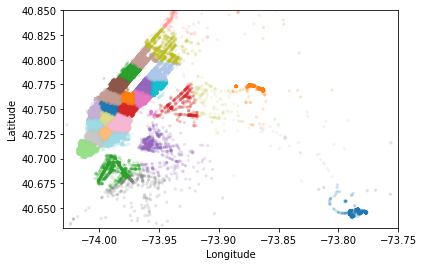

In [13]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt1.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt1.show()

plot_clusters(feb_data_with_durations_outliers_removed)

#### March-2016

In [14]:
#trying different cluster sizes to choose the right K in K-means
coords = mar_data_with_durations_modified[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    mar_data_with_durations_modified['pickup_cluster'] = kmeans.predict(mar_data_with_durations_modified[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

           

In [18]:
# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len) 

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.209373983893206 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 3.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.6137264133988692 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 26.0 
Min inter-cluster distance =  0.5937921096869384 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 33.0 
Min inter-cluster distance =

##### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [15]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 30 clusters using the kmeans 
kmeans_mar = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
mar_data_with_durations_modified['pickup_cluster'] = kmeans_mar.predict(mar_data_with_durations_modified[['pickup_latitude', 'pickup_longitude']])

In [16]:
#with open('features_till_pickup_cluster.pickle', 'wb') as f:
 #   pickle.dump([jan_data_with_durations_outliers_removed, kmeans_jan, feb_data_with_durations_outliers_removed, kmeans_feb, mar_data_with_durations_modified, kmeans_mar], f)

In [9]:
with open('features_till_pickup_cluster.pickle', 'rb') as f:
    jan_data_with_durations_outliers_removed, kmeans_jan, feb_data_with_durations_outliers_removed, kmeans_feb, mar_data_with_durations_modified, kmeans_mar = pickle.load(f)

In [17]:
kmeans_cluster_center = list()
kmeans_cluster_center.extend(kmeans_jan.cluster_centers_)
kmeans_cluster_center.extend(kmeans_feb.cluster_centers_)
kmeans_cluster_center.extend(kmeans_mar.cluster_centers_)

#### Time Binning

In [18]:
# Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1451606400, 1454284800, 1456790400, 1459468800, 1462060800, 1464739200], \
                  [1454284800, 1454371200, 1454457600, 1454544000, 1454630400, 1454716800]]
    
    start_pickup_unix=unix_times[year-2016][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

##### Jan-2016

In [19]:
jan_2016_frame = add_pickup_bins(jan_data_with_durations_outliers_removed,1,2016)
jan_2016_groupby = jan_data_with_durations_outliers_removed[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

##### Feb-2016

In [20]:
feb_2016_frame = add_pickup_bins(feb_data_with_durations_outliers_removed,2,2016)
feb_2016_groupby = feb_data_with_durations_outliers_removed[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

##### March-2016

In [21]:
mar_2016_frame = add_pickup_bins(mar_data_with_durations_modified,3,2016)
mar_2016_groupby = mar_data_with_durations_modified[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [22]:
#with open('features_till_time_bins.pickle', 'wb') as f:
 #   pickle.dump([jan_2016_frame, jan_2016_groupby, feb_2016_frame, feb_2016_groupby, mar_2016_frame, mar_2016_groupby], f)

In [17]:
with open('features_till_time_bins.pickle', 'rb') as f:
    jan_2016_frame, jan_2016_groupby, feb_2016_frame, feb_2016_groupby, mar_2016_frame, mar_2016_groupby = pickle.load(f)

#### Smoothing

In [23]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [24]:
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

In [25]:
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

In [26]:
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [27]:
# for each cluster number of 10min intervels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2016_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  97
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  197
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  77
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  384
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  74
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  81
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  95
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  82
-----------

There are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [28]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that have happened in each region for each 10min intervel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intervel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [29]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intervel
# there wont be any value if there are no pickups.
# values: number of unique bins

# for every 10min intervel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [30]:
#Filling Missing values of Jan-2016 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2016_fill = fill_missing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)

#Smoothing Missing values of Jan-2016
jan_2016_smooth = smoothing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)

In [31]:
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2016_fill)
print("number of 10min intervals among all the clusters ",len(jan_2016_fill))

number of 10min intervals among all the clusters  133920


In [32]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that have happened in each region for each 10min intervel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intervel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing_feb(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4176):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [33]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intervel
# there wont be any value if there are no pickups.
# values: number of unique bins

# for every 10min intervel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing_feb(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4176):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4176):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4176):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4175-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4176):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [34]:
#Filling Missing values of Jan-2016 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
feb_2016_fill = fill_missing_feb(feb_2016_groupby['trip_distance'].values, feb_2016_unique)

#Smoothing Missing values of Train-2016
feb_2016_smooth = smoothing_feb(feb_2016_groupby['trip_distance'].values, feb_2016_unique)

In [35]:
# for each cluster we will have 4176 values, therefore 40*4176 = 167040 (length of the feb_2016_fill)
print("number of 10min intervals among all the clusters ",len(feb_2016_fill))

number of 10min intervals among all the clusters  125280


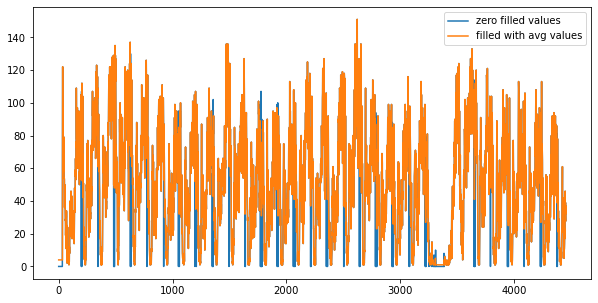

In [36]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt1.figure(figsize=(10,5))
plt1.plot(jan_2016_fill[4464:8920], label="zero filled values")
plt1.plot(jan_2016_smooth[4464:8920], label="filled with avg values")
plt1.legend()
plt1.show()

In [15]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [37]:
# March 2016 data missing values are filled with zero
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values, mar_2016_unique)

'''
    # Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
    regions_cum = []

    # a =[1,2,3]
    # b = [2,3,4]
    # a+b = [1, 2, 3, 2, 3, 4]

    # number of 10min indices for jan 2015= 24*31*60/10 = 4464
    # number of 10min indices for jan 2016 = 24*31*60/10 = 4464
    # number of 10min indices for feb 2016 = 24*29*60/10 = 4176
    # number of 10min indices for march 2016 = 24*31*60/10 = 4464
    # regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
    # that are happened for three months in 2016 data

    for i in range(0,40):
        regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

    # print(len(regions_cum))
    # 40
    # print(len(regions_cum[0]))
    # 13104
'''

'\n    # Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise \n    regions_cum = []\n\n    # a =[1,2,3]\n    # b = [2,3,4]\n    # a+b = [1, 2, 3, 2, 3, 4]\n\n    # number of 10min indices for jan 2015= 24*31*60/10 = 4464\n    # number of 10min indices for jan 2016 = 24*31*60/10 = 4464\n    # number of 10min indices for feb 2016 = 24*29*60/10 = 4176\n    # number of 10min indices for march 2016 = 24*31*60/10 = 4464\n    # regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups \n    # that are happened for three months in 2016 data\n\n    for i in range(0,40):\n        regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])\n\n    # print(len(regions_cum))\n    # 40\n    # print(len(regions_cum[0]))\n    # 13104\n'

In [38]:
#with open('smoothed_data.pickle', 'wb') as f:
 #   pickle.dump([jan_2016_smooth, feb_2016_smooth, mar_2016_smooth], f)

In [34]:
with open('smoothed_data.pickle', 'rb') as f:
    jan_2016_smooth, feb_2016_smooth, mar_2016_smooth = pickle.load(f)

In [39]:
regions_cum = []

# Train-2016 = Jan-2016(31 days)
# 24*31*60/10 = 4464

# Feb-2016(29 days) = 60days
# 24*29*60/10 = 4176

# Test-2016 = March-2016(31 days) 
# 24*31*60/10 = 4464


for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+ \
                       feb_2016_smooth[4176*i:4176*(i+1)]+ \
                       mar_2016_smooth[4464*i:4464*(i+1)])

In [40]:
print(len(regions_cum))

30


In [41]:
print(len(regions_cum[0]))

13104


## Time series and Fourier Transforms

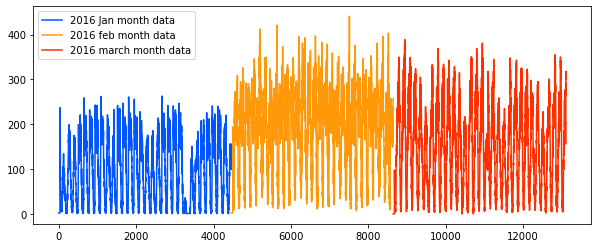

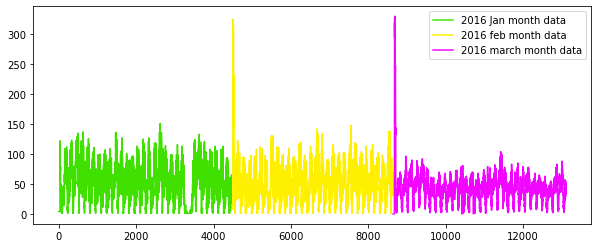

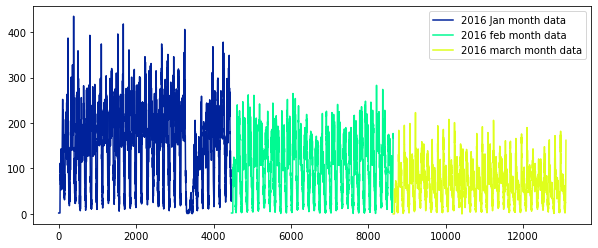

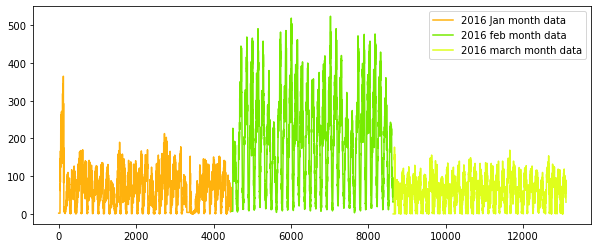

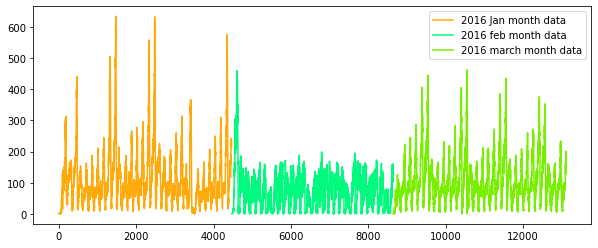

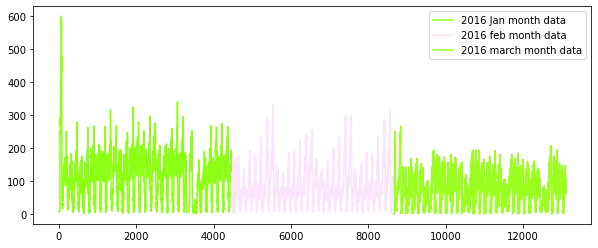

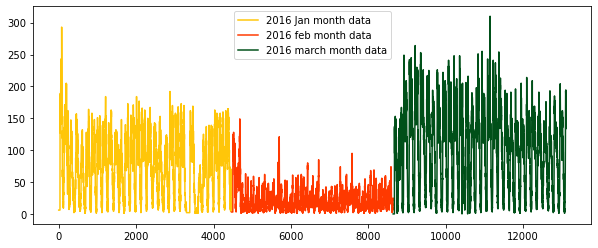

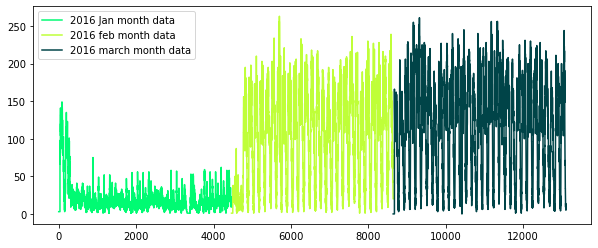

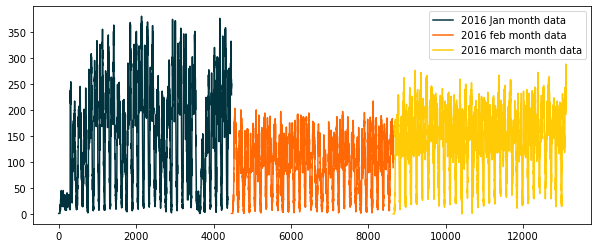

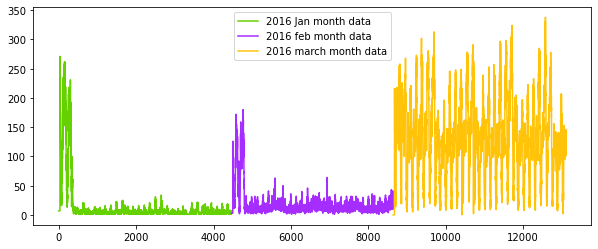

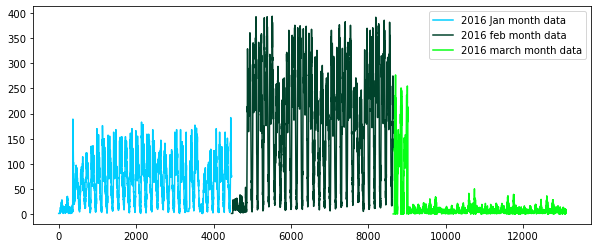

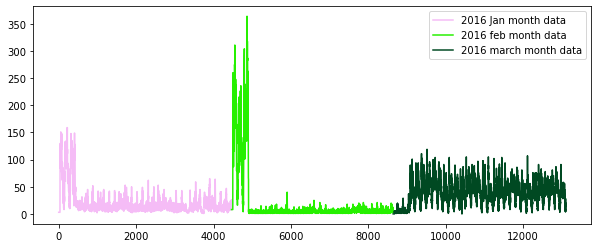

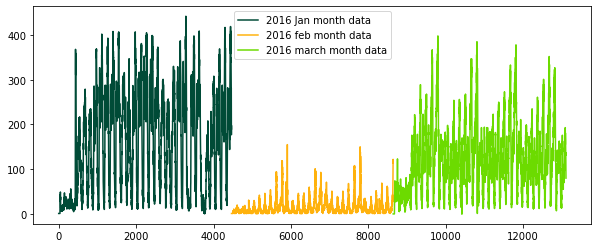

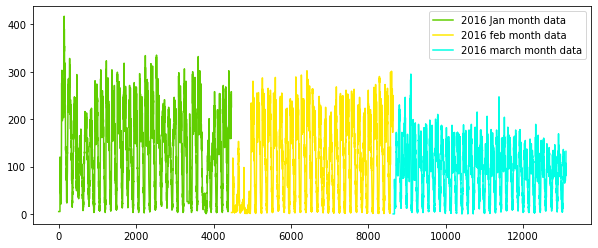

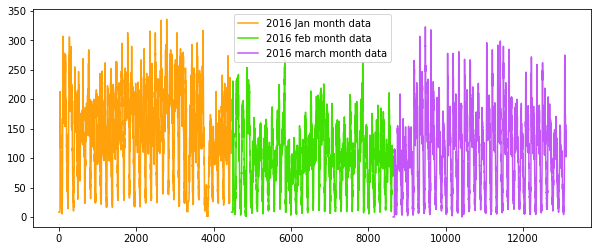

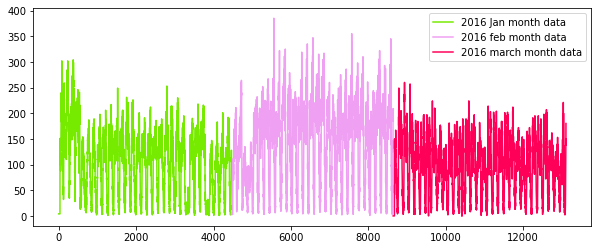

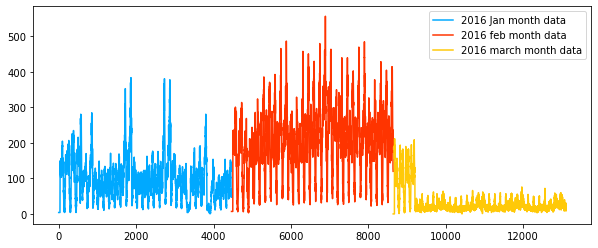

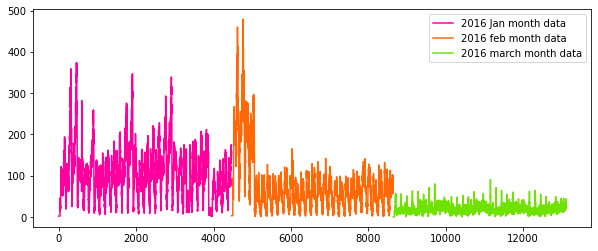

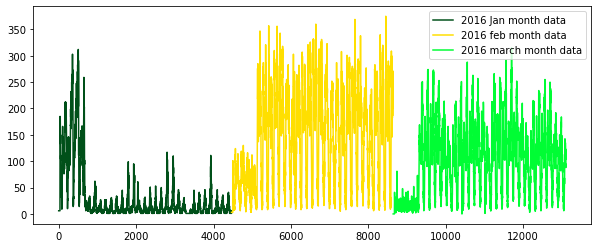

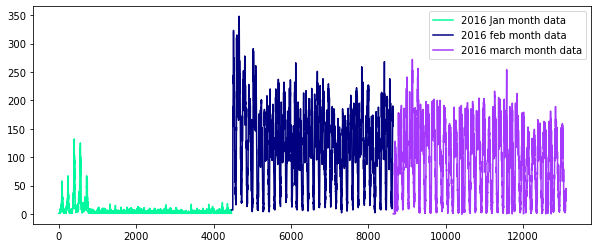

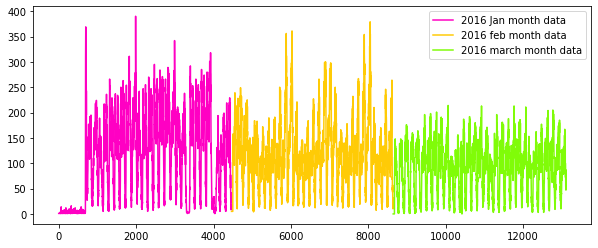

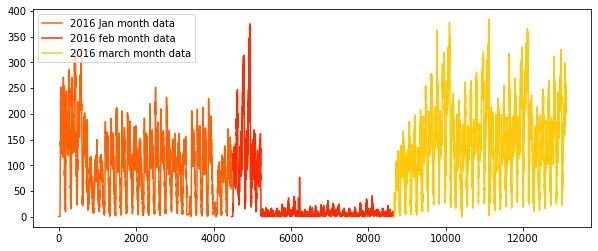

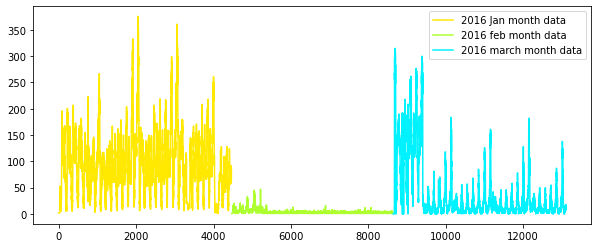

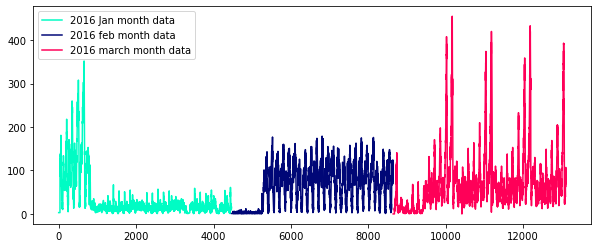

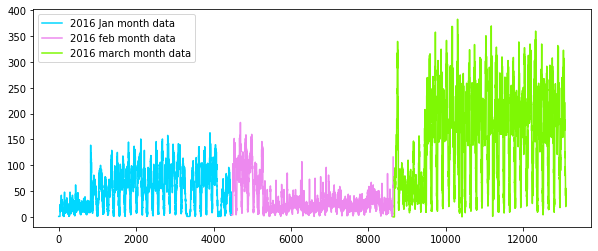

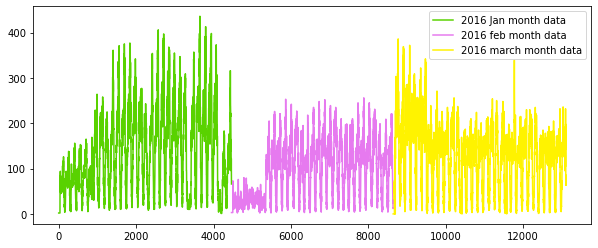

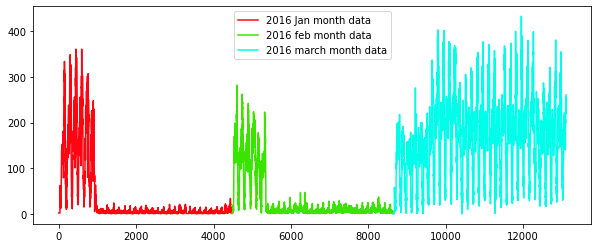

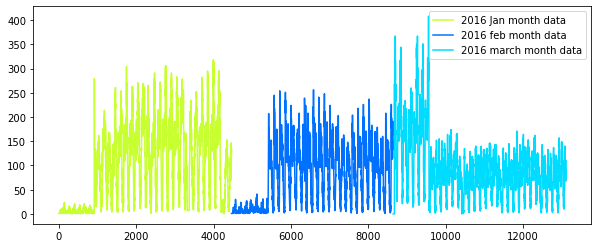

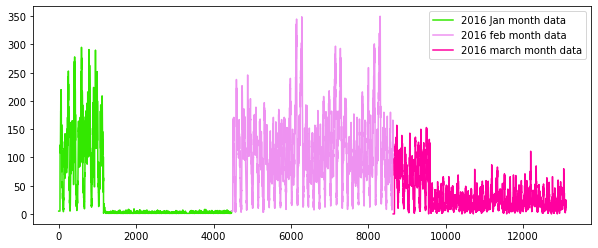

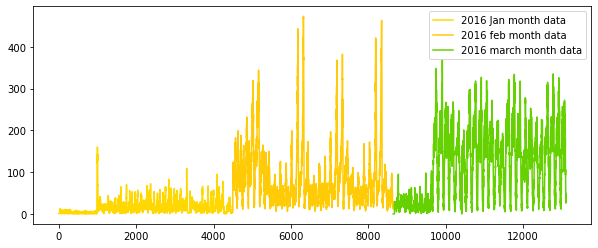

In [42]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt1.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))

for i in range(30):
    plt1.figure(figsize=(10,4))
    plt1.plot(first_x, regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt1.plot(second_x, regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt1.plot(third_x, regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt1.legend()
    plt1.show()

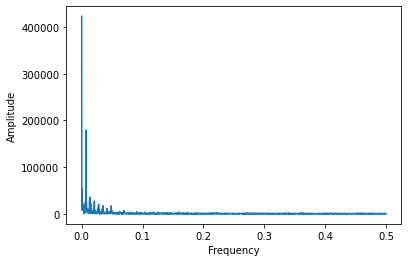

In [43]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4464])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4464, 1)
n = len(freq)
plt1.figure()
plt1.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt1.xlabel("Frequency")
plt1.ylabel("Amplitude")
plt1.show()

In [44]:
amplitude_lists_1 = []
frequency_lists_1 = []

amplitude_lists_2 = []
frequency_lists_2 = []

amplitude_lists_3 = []
frequency_lists_3 = []

amplitude_lists_4 = []
frequency_lists_4 = []

amplitude_lists_5 = []
frequency_lists_5 = []

for i in range(30):
    ampli_jan  = np.abs(np.fft.fft(regions_cum[i][:4464]))
    freq_jan = np.abs(np.fft.fftfreq(4464, 1))
    
    ampli_feb  = np.abs(np.fft.fft(regions_cum[i][4464:8640]))
    freq_feb = np.abs(np.fft.fftfreq(4464, 1))
    
    ampli_mar  = np.abs(np.fft.fft(regions_cum[i][8640:]))
    freq_mar = np.abs(np.fft.fftfreq(4464, 1))
    
    ampli_indices_jan = np.argsort(-ampli_jan)[1:] 
    ampli_indices_feb = np.argsort(-ampli_feb)[1:] 
    ampli_indices_mar = np.argsort(-ampli_mar)[1:]     
    
    amplitude_values = []
    frequency_values = []
    
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli_jan[ampli_indices_jan[j]] + \
                                ampli_feb[ampli_indices_feb[j]] + \
                                ampli_mar[ampli_indices_mar[j]])
        frequency_values.append(freq_jan[ampli_indices_jan[j]] + \
                                freq_feb[ampli_indices_feb[j]] + \
                                freq_mar[ampli_indices_mar[j]])
    
    for k in range(13099):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists_1.append(amplitude_values[0])
        frequency_lists_1.append(frequency_values[0])
        
        amplitude_lists_2.append(amplitude_values[1])
        frequency_lists_2.append(frequency_values[1])
        
        amplitude_lists_3.append(amplitude_values[2])
        frequency_lists_3.append(frequency_values[2])
        
        amplitude_lists_4.append(amplitude_values[3])
        frequency_lists_4.append(frequency_values[3])
        
        amplitude_lists_5.append(amplitude_values[4])
        frequency_lists_5.append(frequency_values[4])

In [45]:
len(frequency_lists_1)

392970

In [46]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
import pandas as pd

ratios = pd.DataFrame()
ratios['Given']=jan_2016_smooth
ratios['Prediction']=mar_2016_smooth
ratios['Ratios']=ratios['Prediction']*1.0/ratios['Given']*1.0

## Modelling-Baseline Models

### 1. Simple Moving Averages

In [47]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [48]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### 2. Weighted Moving Averages

In [49]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [50]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### 3. Exponential Weighted Moving Averages

In [51]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [52]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [53]:
mean_err=[0]*10
median_err=[0]*10
ratios,mean_err[0],median_err[0]=MA_R_Predictions(ratios,'jan-march')
ratios,mean_err[1],median_err[1]=MA_P_Predictions(ratios,'jan-march')
ratios,mean_err[2],median_err[2]=WA_R_Predictions(ratios,'jan-march')
ratios,mean_err[3],median_err[3]=WA_P_Predictions(ratios,'jan-march')
ratios,mean_err[4],median_err[4]=EA_R1_Predictions(ratios,'jan-march')
ratios,mean_err[5],median_err[5]=EA_P1_Predictions(ratios,'jan-march')

### Comparison between Baseline Models

In [54]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["MODEL", "MAPE", "MSE"]
x.add_row(['Moving Averages (Ratios)', mean_err[0], median_err[0]])
x.add_row(['Moving Averages (2016 Values)', mean_err[1], median_err[1]])
x.add_row(['Weighted Moving Averages (Ratios)', mean_err[2], median_err[2]])
x.add_row(['Weighted Moving Averages (2016 Values)', mean_err[3], median_err[3]])
x.add_row(['Exponential Moving Averages (Ratios)', mean_err[4], median_err[4]])
x.add_row(['Exponential Moving Averages (2016 Values)', mean_err[5], median_err[5]])
print(x)

+-------------------------------------------+---------------------+--------------------+
|                   MODEL                   |         MAPE        |        MSE         |
+-------------------------------------------+---------------------+--------------------+
|          Moving Averages (Ratios)         |  0.3030079682132933 | 6149.018787335723  |
|       Moving Averages (2016 Values)       | 0.12544941100692916 | 290.90839307048986 |
|     Weighted Moving Averages (Ratios)     |  0.304229176668764  | 6542.6292936081245 |
|   Weighted Moving Averages (2016 Values)  | 0.11988286073734054 | 269.16315710872163 |
|    Exponential Moving Averages (Ratios)   |  0.3062518782406381 | 6433.230540621266  |
| Exponential Moving Averages (2016 Values) | 0.11979745980689283 | 267.1532930107527  |
+-------------------------------------------+---------------------+--------------------+


The above comparison is on Jan and March 2016 data

### Double Exponential Smoothing

In [55]:
print(len(jan_2016_smooth)/30)

4464.0


In [56]:
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [57]:
smoothed_result_jan = double_exponential_smoothing(jan_2016_smooth, 0.9, 0.9)[:-1]

In [58]:
smoothed_result_feb = double_exponential_smoothing(feb_2016_smooth, 0.9, 0.9)[:-1]

In [59]:
smoothed_result_mar = double_exponential_smoothing(mar_2016_smooth, 0.9, 0.9)[:-1]

In [60]:
len(smoothed_result_mar) + len(smoothed_result_feb) + len(smoothed_result_jan)

393120

In [61]:
jan =[]
for i in range(30):
    jan.extend(smoothed_result_jan[i*4464:(i+1)*4464][5:])

In [62]:
double_smoothed_data = list()
double_smoothed_data.extend(jan+smoothed_result_feb+smoothed_result_mar)

In [63]:
print(len(double_smoothed_data))

392970


In [64]:
#with open('double_exponential_smoothing_predictions.pickle', 'wb') as f:
 #   pickle.dump([smoothed_result_jan, smoothed_result_feb, smoothed_result_mar], f)

In [42]:
with open('double_exponential_smoothing_predictions.pickle', 'rb') as f:
    smoothed_result_jan, smoothed_result_feb, smoothed_result_mar = pickle.load(f)

In [65]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,30):
    tsne_lat.append([kmeans_cluster_center[i][0]]*13099)
    tsne_lon.append([kmeans_cluster_center[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 30 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [66]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*13099 == len(output)*len(output[0])

True

In [67]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [68]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [69]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [70]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 30 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 30 Number of data points in test data 3930 Each data point contains 5 features


In [71]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [72]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [73]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [74]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [75]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [76]:
len(double_smoothed_data)

392970

In [77]:
len(train_new_features)

275070

In [78]:
len(test_new_features)

117900

In [79]:
double_exp_smoothed_X_train = double_smoothed_data[:275070]
double_exp_smoothed_X_test = double_smoothed_data[275070:]

In [80]:
frequency_X_train_1 = frequency_lists_1[:275070]
frequency_X_test_1 = frequency_lists_1[275070:]

frequency_X_train_2 = frequency_lists_2[:275070]
frequency_X_test_2 = frequency_lists_2[275070:]

frequency_X_train_3 = frequency_lists_3[:275070]
frequency_X_test_3 = frequency_lists_3[275070:]

frequency_X_train_4 = frequency_lists_4[:275070]
frequency_X_test_4 = frequency_lists_4[275070:]

frequency_X_train_5 = frequency_lists_5[:275070]
frequency_X_test_5 = frequency_lists_5[275070:]

In [81]:
amplitude_X_train_1 = amplitude_lists_1[:275070]
amplitude_X_test_1 = amplitude_lists_1[275070:]

amplitude_X_train_2 = amplitude_lists_2[:275070]
amplitude_X_test_2 = amplitude_lists_2[275070:]

amplitude_X_train_3 = amplitude_lists_3[:275070]
amplitude_X_test_3 = amplitude_lists_3[275070:]

amplitude_X_train_4 = amplitude_lists_4[:275070]
amplitude_X_test_4 = amplitude_lists_4[275070:]

amplitude_X_train_5 = amplitude_lists_5[:275070]
amplitude_X_test_5 = amplitude_lists_5[275070:]

In [82]:
len(double_exp_smoothed_X_train)

275070

In [83]:
len(double_exp_smoothed_X_test)

117900

In [84]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = double_exp_smoothed_X_train
df_train['frequency-1'] = frequency_X_train_1
df_train['frequency-2'] = frequency_X_train_2
df_train['frequency-3'] = frequency_X_train_3
df_train['frequency-4'] = frequency_X_train_4
df_train['frequency-5'] = frequency_X_train_5
df_train['amplitude-1'] = amplitude_X_train_1
df_train['amplitude-2'] = amplitude_X_train_2
df_train['amplitude-3'] = amplitude_X_train_3
df_train['amplitude-4'] = amplitude_X_train_4
df_train['amplitude-5'] = amplitude_X_train_5

print(df_train.shape)

(275070, 19)


In [85]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = double_exp_smoothed_X_test
df_test['frequency-1'] = frequency_X_test_1
df_test['frequency-2'] = frequency_X_test_2
df_test['frequency-3'] = frequency_X_test_3
df_test['frequency-4'] = frequency_X_test_4
df_test['frequency-5'] = frequency_X_test_5
df_test['amplitude-1'] = amplitude_X_test_1
df_test['amplitude-2'] = amplitude_X_test_2
df_test['amplitude-3'] = amplitude_X_test_3
df_test['amplitude-4'] = amplitude_X_test_4
df_test['amplitude-5'] = amplitude_X_test_5
print(df_test.shape)

(117900, 19)


In [86]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0     2     2     2     2     2  40.772619 -73.962204        4      2.0   
1     2     2     2     2     2  40.772619 -73.962204        4      2.0   
2     2     2     2     2     2  40.772619 -73.962204        4      2.0   
3     2     2     2     2     2  40.772619 -73.962204        4      2.0   
4     2     2     2     2     2  40.772619 -73.962204        4      2.0   

   frequency-1  frequency-2  frequency-3  frequency-4  frequency-5  \
0     0.084901     0.092294     0.091622      0.09767     0.091846   
1     0.084901     0.092294     0.091622      0.09767     0.091846   
2     0.084901     0.092294     0.091622      0.09767     0.091846   
3     0.084901     0.092294     0.091622      0.09767     0.091846   
4     0.084901     0.092294     0.091622      0.09767     0.091846   

     amplitude-1   amplitude-2    amplitude-3    amplitude-4    amplitude-5  
0  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
1  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
2  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
3  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
4  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665

In [87]:
#with open('Final_Dataset.pickle', 'wb') as f:
 #   pickle.dump([df_train, tsne_train_output, df_test, tsne_test_output], f)

In [2]:
with open('Final_Dataset.pickle', 'rb') as f:
    df_train, tsne_train_output, df_test, tsne_test_output = pickle.load(f)

In [3]:
param_grid = {'n_estimators': [500, 700, 1000, 1500, 2000], \
              'max_depth': [3, 4, 5, 7, 9, 10], 'subsample': [0.7], \
              'colsample_bytree': [1], 'colsample_bylevel': [1], 'colsample_bynode': [1], \
              'gamma': [1], 'reg_alpha': [0.3], 'reg_lambda': [0.3]}

In [4]:
xgboostReg = xgb.XGBRegressor()

In [5]:
grid_xgb = GridSearchCV(xgboostReg, param_grid, cv = 3, n_jobs = -1)

In [6]:
grid_xgb.fit(df_train, tsne_train_output)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [7]:
print("Best Parameters: ", grid_xgb.best_params_)
print("Best Score: ",grid_xgb.best_score_)
print("Best estimator: ", grid_xgb.best_estimator_)

Best Parameters:  {'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 0.7}
Best Score:  0.9604886936950576
Best estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.3, reg_lambda=0.3, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [8]:
x_model = grid_xgb.best_estimator_

In [9]:
x_model.fit(df_train, tsne_train_output)
y_pred_test = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred_test]
y_pred_train = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred_train]

In [10]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0     2     2     2     2     2  40.772619 -73.962204        4      2.0   
1     2     2     2     2     2  40.772619 -73.962204        4      2.0   
2     2     2     2     2     2  40.772619 -73.962204        4      2.0   
3     2     2     2     2     2  40.772619 -73.962204        4      2.0   
4     2     2     2     2     2  40.772619 -73.962204        4      2.0   

   frequency-1  frequency-2  frequency-3  frequency-4  frequency-5  \
0     0.084901     0.092294     0.091622      0.09767     0.091846   
1     0.084901     0.092294     0.091622      0.09767     0.091846   
2     0.084901     0.092294     0.091622      0.09767     0.091846   
3     0.084901     0.092294     0.091622      0.09767     0.091846   
4     0.084901     0.092294     0.091622      0.09767     0.091846   

     amplitude-1   amplitude-2    amplitude-3    amplitude-4    amplitude-5  
0  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
1  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
2  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
3  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665  
4  625485.897928  229967.67746  128027.221927  113579.528331  105575.985665

In [11]:
x_model.feature_importances_

array([0.00180751, 0.00140579, 0.00457491, 0.09938733, 0.86543345,
       0.00227747, 0.00217095, 0.00162026, 0.00123808, 0.0016253 ,
       0.00169744, 0.00194311, 0.00171433, 0.00177506, 0.00233463,
       0.00231331, 0.00186912, 0.00260931, 0.00220259], dtype=float32)

In [12]:
train_mape=[]
test_mape=[]
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [13]:
print(train_mape[0])

0.11570243526371955


In [14]:
print(test_mape[0])

0.1185000537592237


## Comparison of MAPE between different Models

In [1]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'Train MAPE %', 'Test MAPE %']
x.add_row(['XGBoostRegressor', '0.11570243526371955', '0.1185000537592237'])
print(x)

+------------------+---------------------+--------------------+
|      Model       |     Train MAPE %    |    Test MAPE %     |
+------------------+---------------------+--------------------+
| XGBoostRegressor | 0.11570243526371955 | 0.1185000537592237 |
+------------------+---------------------+--------------------+


## Conclusion

Since only ratio models were trained on Jan and March 2016 data, they could not be compared with Regression Models, as the regression models were train on complete three month(Jan, Feb & March 2016 data).

As told by mentor only XGBoost Regressor was trained and the MAPE is shown in the table above.

This is the lowest MAPE trained and tested by XGBoost Regressor model on the complete three month data.

So, I have successfully calculated Test MAPE below 12%.